In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Linear, Dropout, LayerNorm
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, global_add_pool
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau

import networkx as nx

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns
from statistics import mean
import random
import uproot

In [84]:
path_to_tree = "DecayTreeTuple/tuple"

def rename_columns(df):
    new_columns = {}
    for col in df.columns:
        if "_BDTTag_" in col:
            new_columns[col] = col.replace("_BDTTag_", "_SVtag_")
    df.rename(columns=new_columns, inplace=True)

# maybe don't need
def extract_float(awk_array):
    return awk_array[0] if len(awk_array) > 0 else None

In [85]:
# Read the ROOT file
tree = uproot.open("Dijet_bb_pt20_50_dw.root" + ":" + path_to_tree)
full_bb_df = tree.arrays(tree.keys(), library="pd", entry_start=0, entry_stop=600000) #1000-2000 events read in

# Clean column names and remove unwanted columns
full_bb_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in full_bb_df.columns]
rename_columns(full_bb_df)
columns_to_remove = [col for col in full_bb_df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
full_bb_df.drop(columns=columns_to_remove, inplace=True)
for col in full_bb_df.columns:
    if "SVtag" in col:
        full_bb_df[col] = full_bb_df[col].apply(extract_float)
tree.close()

# Read the ROOT file
tree = uproot.open("Dijet_cc_pt20_50_dw.root" + ":" + path_to_tree)
full_cc_df = tree.arrays(tree.keys(), library="pd", entry_start=0, entry_stop=600000) #1000-2000 events read in

# Clean column names and remove unwanted columns
full_cc_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in full_cc_df.columns]
rename_columns(full_cc_df)
columns_to_remove = [col for col in full_cc_df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
full_cc_df.drop(columns=columns_to_remove, inplace=True)
for col in full_cc_df.columns:
    if "SVtag" in col:
        full_cc_df[col] = full_cc_df[col].apply(extract_float)
tree.close()

In [86]:
# Read from csv
sig_df = full_cc_df
bkg_df = full_bb_df

full_df = pd.concat([sig_df, bkg_df]).reset_index(drop=True)

# Assign truth labels: 1 for signal (c-jet) and 0 for background (b-jet)
sig_df['IsC'] = 1
bkg_df['IsC'] = 0

# Filter columns to include only leading jet data and truth labels
sig_df = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet0|IsC")]]
bkg_df = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet0|IsC")]]

# Apply cuts and truth matching
sig_df = sig_df[(sig_df['Jet0_MC_Match'] == 1) &
                (sig_df['Jet0_MC_Jet_EfD'] > 0.6) &
                (sig_df['Jet0_PT'] > 20000) &
                (sig_df['Jet0_Eta'].between(2.2, 4.4))]
bkg_df = bkg_df[(bkg_df['Jet0_MC_Match'] == 1) &
                (bkg_df['Jet0_MC_Jet_EfB'] > 0.6) &
                (bkg_df['Jet0_PT'] > 20000) &
                (bkg_df['Jet0_Eta'].between(2.2, 4.4))]

# Combine signal and background
combined_df = pd.concat([sig_df, bkg_df]).reset_index(drop=True)

# Define feature columns including jet-level and daughter-level features
daughter_cols = [col for col in sig_df.columns if "_Daughters" in col]
svtag_cols = ['Jet0_SVtag_fdrMin',
 'Jet0_SVtag_ptSvrJet',
 'Jet0_SVtag_nTrk',
 'Jet0_SVtag_nTrkJet',
 'Jet0_SVtag_drSvrJet',
 'Jet0_SVtag_absQSum',
 'Jet0_SVtag_m',
 'Jet0_SVtag_mCor',
 'Jet0_SVtag_fdChi2',
 'Jet0_SVtag_ipChi2Sum',
 'Jet0_SVtag_tau',
 'Jet0_SVtag_z',
 'Jet0_SVtag_pt']
jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
feature_cols = daughter_cols + jet_cols

In [87]:
combined_df

,Jet0_ENDVERTEX_X,Jet0_ENDVERTEX_Y,Jet0_ENDVERTEX_Z,Jet0_ENDVERTEX_XERR,Jet0_ENDVERTEX_YERR,Jet0_ENDVERTEX_ZERR,Jet0_ENDVERTEX_CHI2,Jet0_ENDVERTEX_NDOF,Jet0_OWNPV_X,Jet0_OWNPV_Y,...,Jet0_Hlt1Phys_Dec,Jet0_Hlt1Phys_TIS,Jet0_Hlt1Phys_TOS,Jet0_Hlt2Global_Dec,Jet0_Hlt2Global_TIS,Jet0_Hlt2Global_TOS,Jet0_Hlt2Phys_Dec,Jet0_Hlt2Phys_TIS,Jet0_Hlt2Phys_TOS,IsC
0,0.8085,-0.1778,3.4408,0.0076,0.0076,0.0489,76.717255,161,0.808109,-0.176474,...,True,True,True,True,True,True,True,True,True,1
1,0.8314,-0.1143,-35.5991,0.0107,0.0105,0.0492,21.659010,69,0.831405,-0.114842,...,True,True,True,True,True,True,True,True,True,1
2,0.8572,-0.2037,-59.2924,0.0077,0.0074,0.0416,62.285351,143,0.857428,-0.204979,...,True,True,True,True,True,True,True,True,True,1
3,0.8572,-0.2037,-59.2924,0.0077,0.0074,0.0416,62.285351,143,0.857428,-0.204979,...,True,True,True,True,True,True,True,True,True,1
4,0.8572,-0.2037,-59.2924,0.0077,0.0074,0.0416,62.285351,143,0.857428,-0.204979,...,True,True,True,True,True,True,True,True,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338295,0.8528,-0.2004,-15.8459,0.0070,0.0071,0.0337,87.629677,187,0.852070,-0.199535,...,True,True,True,True,True,True,True,True,True,0
338296,0.8647,-0.1720,-17.7439,0.0069,0.0069,0.0368,65.498283,161,0.865574,-0.171921,...,False,False,False,True,False,False,True,False,False,0
338297,0.8647,-0.1720,-17.7439,0.0069,0.0069,0.0368,65.498283,161,0.865574,-0.171921,...,False,False,False,True,False,False,True,False,False,0
338298,0.8647,-0.1720,-17.7439,0.0069,0.0069,0.0368,65.498283,161,0.865574,-0.171921,...,False,False,False,True,False,False,True,False,False,0


In [88]:
sum(combined_df.IsC)

130468

In [71]:
# Prepare features by converting daughter information to lists and duplicating jet-level features
def prepare_features(df, jet_cols, daughter_cols):
    # Duplicate data to lists matching the number of daughters/nodes per jet/row
    for col in jet_cols:
        df[col] = df.apply(lambda row: [row[col]] * row['Jet0_nDaughters'] if isinstance(row[col], (float, int)) else row[col], axis=1)

    # Convert string values into list of floats
    for col in daughter_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

df = prepare_features(combined_df, jet_cols, daughter_cols)

# Split data into training, validation, and test sets
sig_df = df[df['IsC'] == 1].sample(frac=1, random_state=42).reset_index(drop=True)
bkg_df = df[df['IsC'] == 0].sample(frac=1, random_state=42).reset_index(drop=True)

half_train_size = 500
half_test_size = 500

train_df = pd.concat([sig_df.head(half_train_size), bkg_df.head(half_train_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([sig_df.tail(half_test_size), bkg_df.tail(half_test_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
validation_df = pd.concat([sig_df.iloc[half_train_size:-half_test_size], bkg_df.iloc[half_train_size:-half_test_size]]).sample(frac=1, random_state=42).reset_index(drop=True)

In [72]:
# Create graphs for training and testing
def create_graphs(df, feature_cols):

    features_list = []
    
    for _, row in df.iterrows():
        num_nodes = row['Jet0_nDaughters']
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    data_objects = []
    for idx, features in enumerate(features_list):

        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        # Create fully connected graph
        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        y = torch.tensor([df['IsC'].iloc[idx]], dtype=torch.float)
        
        data = Data(x=x, edge_index=edge_index, y=y, num_nodes=num_nodes)
        data_objects.append(data)

    return data_objects

# Create graphs for training and testing
train_data = create_graphs(train_df, feature_cols)
test_data = create_graphs(test_df, feature_cols)

# Load data in batches
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [73]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        hidden_channels = 64
        self.conv1 = SAGEConv(len(feature_cols), hidden_channels)
        self.ln1 = LayerNorm(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.ln2 = LayerNorm(hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.ln3 = LayerNorm(hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)
        self.ln4 = LayerNorm(hidden_channels)
        self.lin = Linear(hidden_channels, 1)
        self.dropout = Dropout(0.3)

    def forward(self, x, edge_index, batch):        
        x = self.conv1(x, edge_index)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.ln2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = self.ln3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv4(x, edge_index)
        x = self.ln4(x)
        x = F.relu(x)

        x = global_add_pool(x, batch)
        x = self.lin(x)
        return x.squeeze(1)
    
model = GNN()

In [74]:
# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5) # reduce lr by 0.5 every 5 epochs


# Training loop
def train():
    model.train()
    total_loss = 0

    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y.float())
        clip_grad_norm_(model.parameters(), max_norm=0.5)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    avg_loss = total_loss / len(train_loader.dataset)

    return avg_loss

# Testing function
def test(loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0
    
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y.float())
            pred = (out > 0).float()
            correct = (pred.squeeze() == data.y.float()).sum().item()
            total_correct += correct
            total_samples += len(data.y)
            total_loss += loss.item() * data.num_graphs

        avg_loss = total_loss / len(loader.dataset)
        acc = total_correct / total_samples
    return avg_loss, acc

# Training parameters
num_epochs = 200

# Initialize lists for storing loss and accuracy values
train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []

'''best_loss = float('inf')
best_model_weights = None
patience = 15'''

# Training loop
for epoch in range(num_epochs):

    train_loss = train()
    train_loss_values.append(train_loss)

    train_acc = test(train_loader)[1]
    train_acc_values.append(train_acc)

    test_loss, test_acc = test(test_loader)
    test_loss_values.append(test_loss)
    test_acc_values.append(test_acc)

    # Early stopping after 15 epochs if test loss does not improve
    '''if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), 'morestats2_model.pth')
        patience = 15
    else:
        patience -= 1
        if patience == 0:
            break'''

    scheduler.step(test_loss)

    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    
torch.save(model.state_dict(), 'cb_model.pth')
#model.load_state_dict(torch.load('fullrun_model.pth'))
final_test_loss, final_test_acc = test(test_loader)
print(f'Final Test Loss: {final_test_loss:.4f}, Final Test Acc: {final_test_acc:.4f}')

Epoch: 001, Train Loss: 1.4944, Test Loss: 1.3605, Train Acc: 0.5420, Test Acc: 0.5640
Epoch: 002, Train Loss: 0.9464, Test Loss: 0.7427, Train Acc: 0.6150, Test Acc: 0.6120
Epoch: 003, Train Loss: 0.8078, Test Loss: 0.8010, Train Acc: 0.5960, Test Acc: 0.6140
Epoch: 004, Train Loss: 0.7866, Test Loss: 0.7256, Train Acc: 0.6240, Test Acc: 0.6330
Epoch: 005, Train Loss: 0.7472, Test Loss: 0.7286, Train Acc: 0.6240, Test Acc: 0.6270
Epoch: 006, Train Loss: 0.7672, Test Loss: 0.6785, Train Acc: 0.6350, Test Acc: 0.6500
Epoch: 007, Train Loss: 0.7249, Test Loss: 0.6315, Train Acc: 0.6630, Test Acc: 0.6700
Epoch: 008, Train Loss: 0.7353, Test Loss: 0.6316, Train Acc: 0.6650, Test Acc: 0.6700
Epoch: 009, Train Loss: 0.7099, Test Loss: 0.6112, Train Acc: 0.6780, Test Acc: 0.6840
Epoch: 010, Train Loss: 0.6963, Test Loss: 0.6027, Train Acc: 0.6900, Test Acc: 0.6910
Epoch: 011, Train Loss: 0.6947, Test Loss: 0.5980, Train Acc: 0.6880, Test Acc: 0.6950
Epoch: 012, Train Loss: 0.6657, Test Loss: 

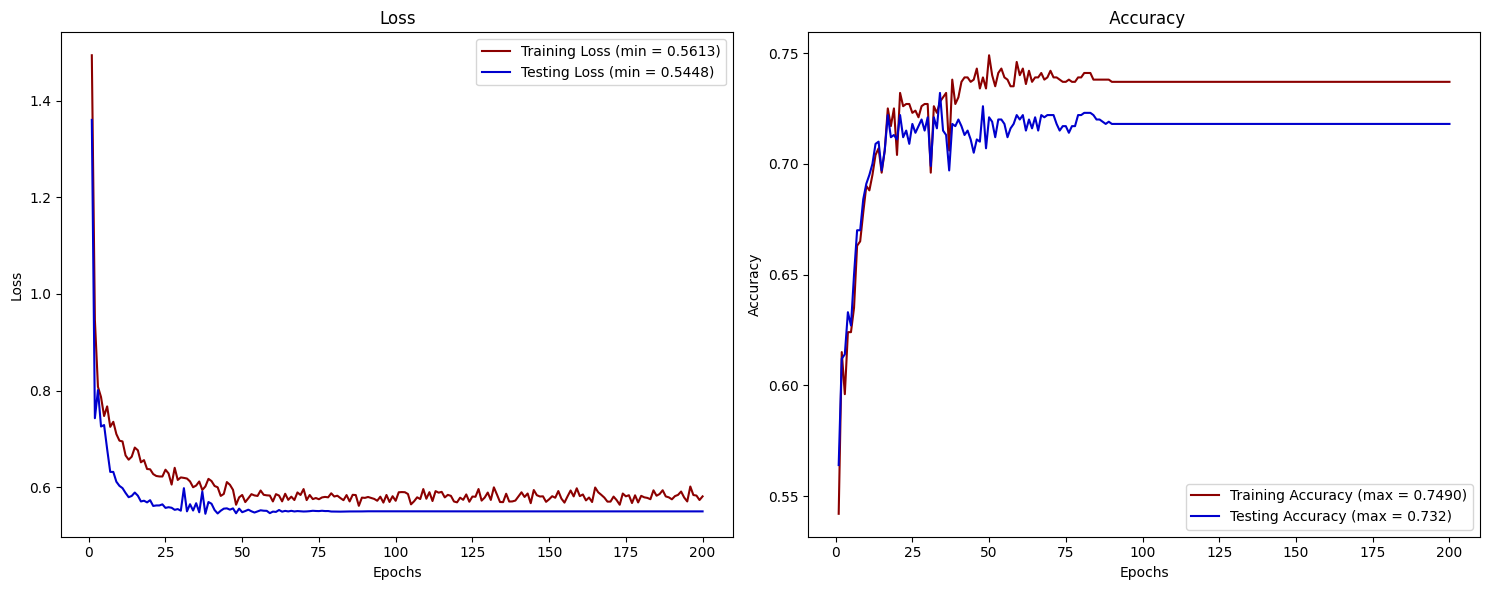

In [75]:
# Plot Loss and Accuracy
def plot_training_results():
    epochs = range(1, len(train_loss_values) + 1)

    mean_train_loss = mean(train_loss_values)
    mean_test_loss = mean(test_loss_values)
    mean_train_acc = mean(train_acc_values)
    mean_test_acc = mean(test_acc_values)

    min_train_loss = min(train_loss_values)
    min_test_loss = min(test_loss_values)
    max_train_acc = max(train_acc_values)
    max_test_acc = max(test_acc_values)

    final_train_loss = train_loss_values[-1]
    final_test_loss = test_loss_values[-1]
    final_train_acc = train_acc_values[-1]
    final_test_acc = test_acc_values[-1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    #fig.suptitle('Training Results', fontsize=16)

    # Plot Loss
    ax1.plot(epochs, train_loss_values, color='darkred', label=(f"Training Loss (min = {min_train_loss:.4f})"))
    ax1.plot(epochs, test_loss_values, color='mediumblue', label=(f"Testing Loss (min = {min_test_loss:.4f})"))
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='best')

    # Plot  Accuracy
    ax2.plot(epochs, train_acc_values, color='darkred', label=(f"Training Accuracy (max = {max_train_acc:.4f})"))
    ax2.plot(epochs, test_acc_values, color='mediumblue', label=(f"Testing Accuracy (max = {max_test_acc:.4})"))
    ax2.set_title(' Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='best')

    plt.style.use('default')
    plt.tight_layout()
    plt.show()
    
# After your training loop, call the function:
plot_training_results()

In [76]:
# Get model predictions
y_true = []  # class values (0 or 1)
y_scores = []  # predicted probabilities or scores

model.eval()
with torch.no_grad():
    for data in test_loader:
        out = model(data.x, data.edge_index, data.batch)
        prob = torch.sigmoid(out)
        
        y_true.append(data.y.numpy().flatten())
        y_scores.append(prob.numpy().flatten())

y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

In [77]:
desired_tpr = 0.8
closest_index = np.argmin(np.abs(tpr - desired_tpr))

# Retrieve the threshold and corresponding FPR for this TPR
chosen_threshold = thresholds[closest_index]
chosen_fpr = fpr[closest_index]

print(f"TPR {desired_tpr}: Pb {chosen_threshold:.4f}: FPR {chosen_fpr:.4f}")

TPR 0.8: Pb 0.4065: FPR 0.3580


In [78]:
# Get FPRs for TPRs
desired_tpr = [.6, .65, .7, 0.75, 0.8, 0.85]

for val in desired_tpr:
    closest_index = np.argmin(np.abs(tpr - val))
    chosen_threshold = thresholds[closest_index]
    chosen_fpr = fpr[closest_index]
    print(f"{val}: {chosen_fpr:.4f}")

0.6: 0.1860
0.65: 0.2240
0.7: 0.2680
0.75: 0.3120
0.8: 0.3580
0.85: 0.4480


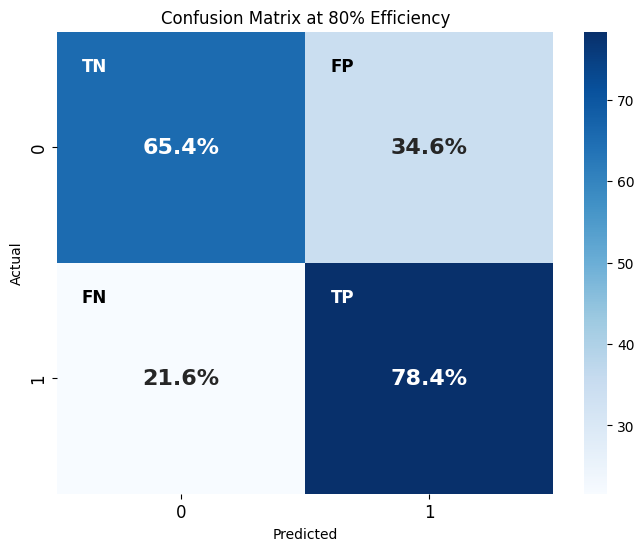

In [79]:
y_pred_binary = (y_scores >= 0.4183).astype(int)
cm = confusion_matrix(y_true, y_pred_binary)

cm_percentage = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis] * 100

annot_labels = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        percentage = cm_percentage[i, j]
        annot_labels[i, j] = f'{percentage:.1f}%'

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm_percentage, annot=annot_labels, fmt='', cmap='Blues', annot_kws={"size": 16, "weight": "bold"})
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix at 80% Efficiency")

ax.text(0.15, 0.15, 'TN', ha='center', va='center', fontweight='bold', fontsize=12, color='white')
ax.text(1.15, 0.15, 'FP', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(0.15, 1.15, 'FN', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(1.15, 1.15, 'TP', ha='center', va='center', fontweight='bold', fontsize=12, color='white')

plt.show()

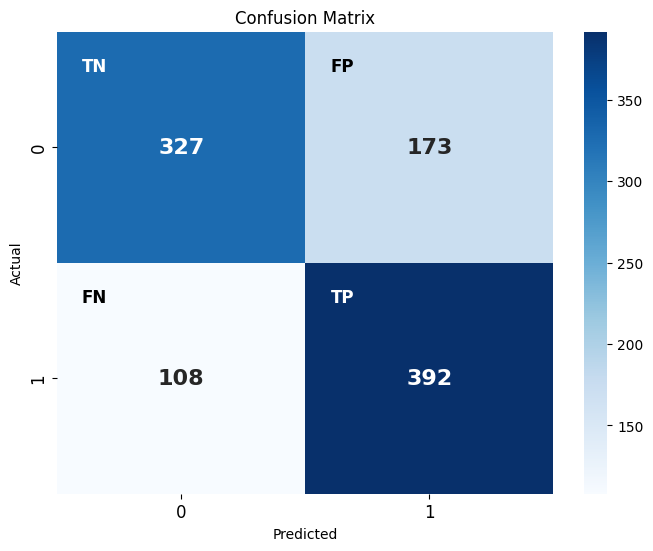

In [80]:
y_pred_binary = (y_scores >= 0.4183).astype(int)
cm = confusion_matrix(y_true, y_pred_binary)
df_cm = pd.DataFrame(cm)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16, "weight": "bold"})
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")

# Add TP, FP, FN, TN labels
ax.text(0.15, 0.15, 'TN', ha='center', va='center', fontweight='bold', fontsize=12, color='white')
ax.text(1.15, 0.15, 'FP', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(0.15, 1.15, 'FN', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(1.15, 1.15, 'TP', ha='center', va='center', fontweight='bold', fontsize=12, color='white')

plt.show()

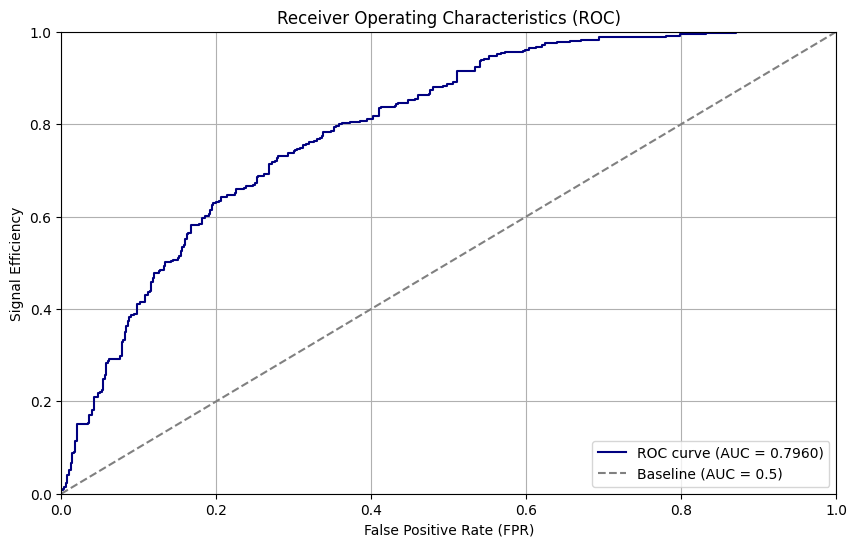

In [81]:
# Plot ROC Curve and show AUC, mark optimal threshold
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='navy', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Baseline (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.style.use('default')
plt.ylabel('Signal Efficiency')
plt.xlabel('False Positive Rate (FPR)')
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

                                Feature  Importance
0                      Jet0_Daughters_E    0.206124
1                     Jet0_Daughters_pT    0.024580
2                     Jet0_Daughters_ID    0.002322
3                     Jet0_Daughters_pX    0.005225
4                     Jet0_Daughters_pY    0.017159
5                     Jet0_Daughters_pZ    0.361021
6                    Jet0_Daughters_Eta    0.000054
7                    Jet0_Daughters_Phi    0.000037
8                      Jet0_Daughters_Q    0.000007
9                     Jet0_Daughters_IP    0.001689
10                Jet0_Daughters_IPCHI2    0.331534
11                 Jet0_Daughters_IPraw    0.000952
12                   Jet0_Daughters_NNe    0.009829
13                   Jet0_Daughters_NNk    0.010691
14                   Jet0_Daughters_NNp    0.017831
15                  Jet0_Daughters_NNpi    0.010444
16                  Jet0_Daughters_NNmu    0.017835
17                  Jet0_Daughters_Chi2    0.020036
18          

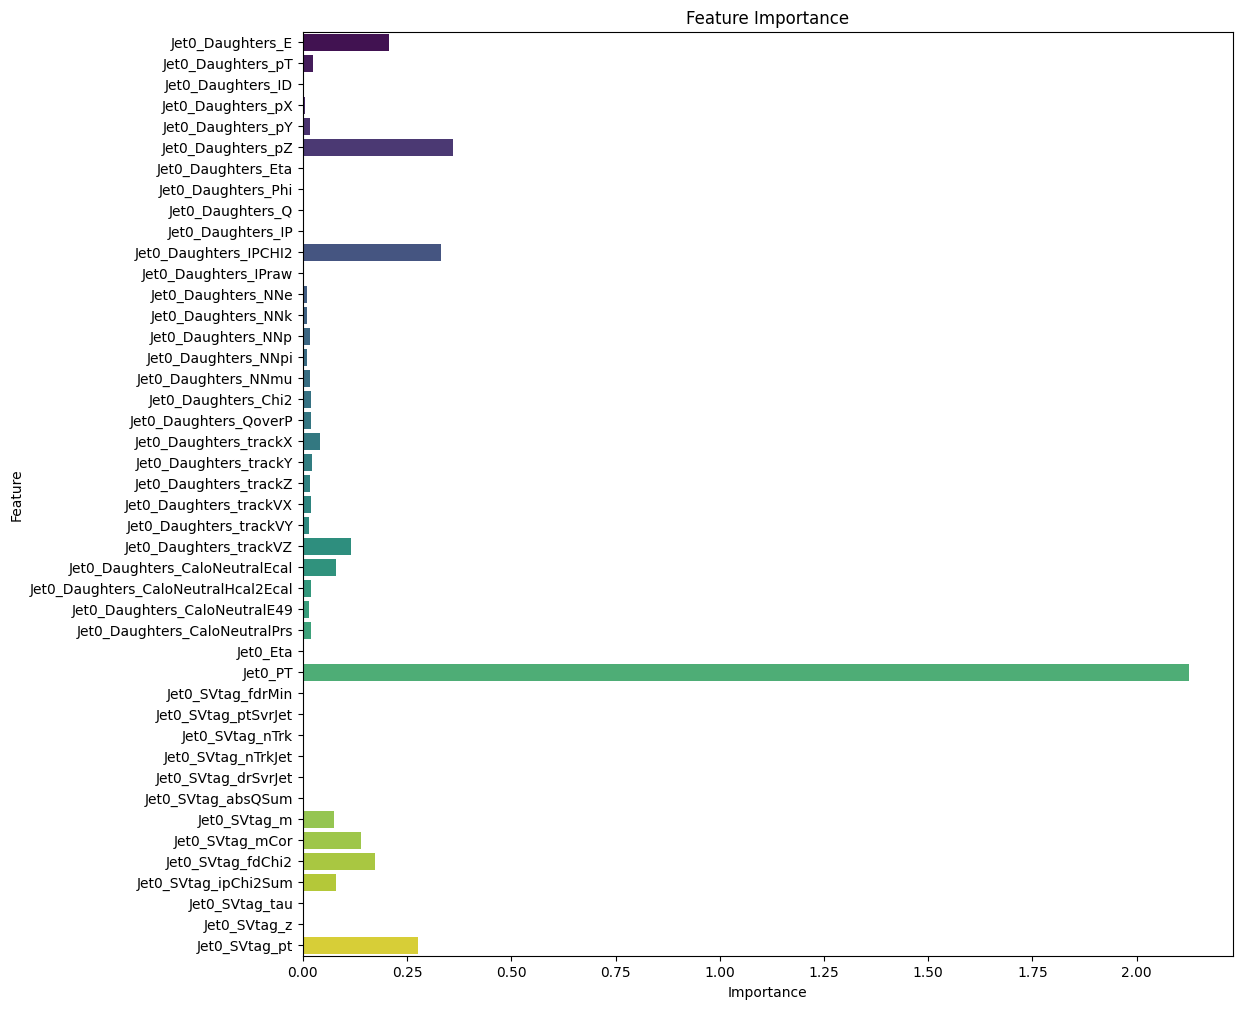

In [82]:
# Prepare model
model.eval()
data = next(iter(test_loader))
x, edge_index, batch = data.x, data.edge_index, data.batch

G = nx.Graph()
edges = list(zip(edge_index[0].numpy(), edge_index[1].numpy()))
G.add_edges_from(edges)

feature_importances = np.zeros(x.size(1))

for feature_idx in range(x.size(1)):
    x_perturbed = x.clone()
    x_perturbed[:, feature_idx] = 0

    # Predict with original features
    with torch.no_grad():
        orig_pred = model(x, edge_index, batch)
        perturbed_pred = model(x_perturbed, edge_index, batch)

    # Compute importance - difference in predictions
    importance = torch.mean(torch.abs(orig_pred - perturbed_pred))
    feature_importances[feature_idx] = importance

importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': feature_importances})
print(importance_df)

plt.figure(figsize=(12, 12))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', hue='Feature', dodge=False)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [83]:
for index, row in importance_df.iterrows():
    feature = row['Feature'] 
    importance = row['Importance']
    if importance > 0.25:
        print(f'{feature} & {importance:4f}')

Jet0_Daughters_pZ & 0.361021
Jet0_Daughters_IPCHI2 & 0.331534
Jet0_PT & 2.124832
Jet0_SVtag_pt & 0.275887
